             A         B         C         D         E         F
1     0.018050 -0.049939  0.006202  0.010938  0.002323 -0.021401
2     0.024767 -0.035505  0.011712  0.010798  0.004565 -0.029324
3     0.001756 -0.011514  0.018986 -0.005734 -0.010983 -0.012628
4     0.002306  0.022015 -0.012544  0.012368  0.022730  0.012929
5    -0.002582  0.005003 -0.010551 -0.006861 -0.013340 -0.017254
...        ...       ...       ...       ...       ...       ...
2515  0.026862 -0.003090  0.017217  0.034924 -0.031245  0.005129
2516 -0.023785  0.017209 -0.037992 -0.001133 -0.004516  0.006023
2517 -0.004039 -0.002996 -0.027822  0.028243 -0.005256  0.006288
2518 -0.022151  0.015486  0.002755  0.001948  0.028864  0.014836
2519  0.014154  0.002815 -0.003770  0.008197 -0.002362  0.003071

[2519 rows x 6 columns]
               A          B           C           D           E           F
1     101.804962  95.006117  100.620233  101.093750  100.232262   97.859860
2     104.326358  91.632940  101.798739  10

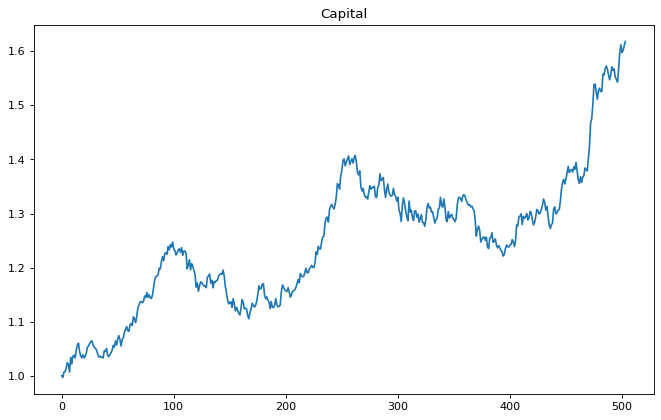

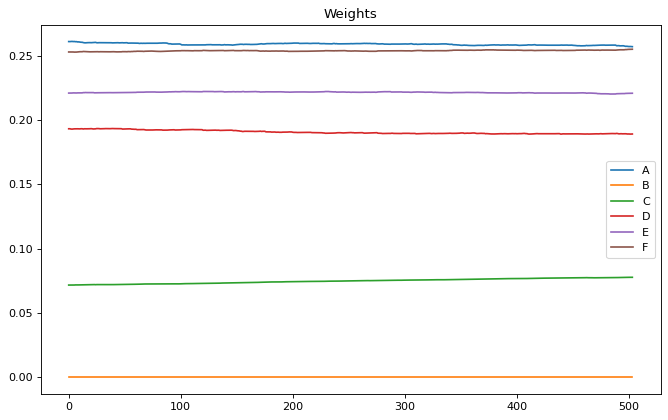

In [18]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from scipy.spatial.distance import squareform

data = pd.read_csv('Case 2 Data 2024.csv', index_col = 0)
daily_returns = data.pct_change().iloc[1:, :]
print(daily_returns)
price = data.iloc[1:, :]
print(price)
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle=False)

k = -1
counter = 0
window = 252*18

data = pd.read_csv('Case 2 Data 2024.csv', index_col = 0)
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)

import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt


from scipy.spatial.distance import squareform
k = -1
counter = 0

window = 252*18

class Allocator():
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''

        self.running_price_paths = train_data.copy()

        self.train_data = train_data.copy()

        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data

    def hrp_optimizer(self, cov_matrix, k, returns_df):
        corr_matrix = cov_matrix.corr()
        dist_matrix = np.sqrt(0.5 * (1 - corr_matrix))
        cond_dist_matrix = squareform(dist_matrix)
        linkage_matrix = sp.cluster.hierarchy.linkage(cond_dist_matrix, 'centroid')
        cluster_assignments = sp.cluster.hierarchy.fcluster(linkage_matrix, k, criterion='inconsistent')
        ivp = 1 / np.diag(cov_matrix)
        ivp /= ivp.sum()

        hrp_weights = pd.Series(index=cov_matrix.columns, dtype=np.float64)
        for id in np.unique(cluster_assignments):
            indices = np.where(cluster_assignments == id)[0]
            covariance = cov_matrix.iloc[indices, indices]
            ivp_cluster = ivp[indices]
            weight = ivp_cluster / np.sum(ivp_cluster)
            hrp_weights[covariance.index] = weight
        hrp_weights /= hrp_weights.sum()

        portfolio_returns = (hrp_weights * returns_df.mean()).sum()
        portfolio_volatility = np.sqrt(np.dot(hrp_weights.T, np.dot(cov_matrix, hrp_weights)))
        portfolio_sharpe_ratio = portfolio_returns / portfolio_volatility

        # # Remove tank asset B, assign to E and F equally
        b_weights = hrp_weights[1] / 2
        hrp_weights[1] = 0
        hrp_weights[4] = hrp_weights[4] + b_weights
        hrp_weights[5] = hrp_weights[5] + b_weights

        return hrp_weights, portfolio_sharpe_ratio, portfolio_returns

    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        global data, daily_returns, k, counter, window
        data = pd.concat([data.iloc[-window:, :], pd.Series(asset_prices, index=data.columns).to_frame().T], axis=0)
        daily_ret = data.pct_change().iloc[1:, :]
        cov_matrix = daily_ret.cov()
        if k == -1:
            k_values = range(1,7)
            best_sharpe_ratio = -np.inf
            best_k = None
            best_weights = None
            for k in k_values:
                hrp_weights, portfolio_sharpe_ratio, portfolio_returns = self.hrp_optimizer(cov_matrix, k, daily_ret)
                if portfolio_sharpe_ratio > best_sharpe_ratio:
                    best_sharpe_ratio = portfolio_sharpe_ratio
                    best_k = k
            k = best_k
        weights, _, _ = self.hrp_optimizer(cov_matrix, k, daily_ret)
        print(counter)
        counter += 1
        return weights

def grading(train_data, test_data):
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")

    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]

    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0

    return sharpe, capital, weights

sharpe, capital, weights = grading(TRAIN, TEST)
#Sharpe gets printed to command line
print("Sharpe ratio: ",sharpe * np.sqrt(252))
print("Weights: ", weights)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()